# fly h1 neuron

- note that ccw is preferred direction
- cw induces silence in the spiking

Paper:
1. Identify the H1 neuron using the oscillating stimulus. Plot the time-varying firing rate.
2. Ok, now we want to look at whether varying the stimulus speeds changes the firing rate of the neuron. We use the same stimulus, but this time we run it at varying speeds in order to look at whether firing rate changes. Ok, not really. Let's look at different stimuli types!
3. Different stimulus types figure.

In [1]:
using PyPlot
using PyCall
using Printf
using Statistics
include("spike_utils.jl")

pyabf = pyimport("pyabf");
sns = pyimport("seaborn");
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["figure.figsize"] = (16,10)
sns.set_context("talk")

In [2]:
recording = pyabf.ABF("data/19o09012-fly2-csf-osc-ccw-5s-2so.abf");

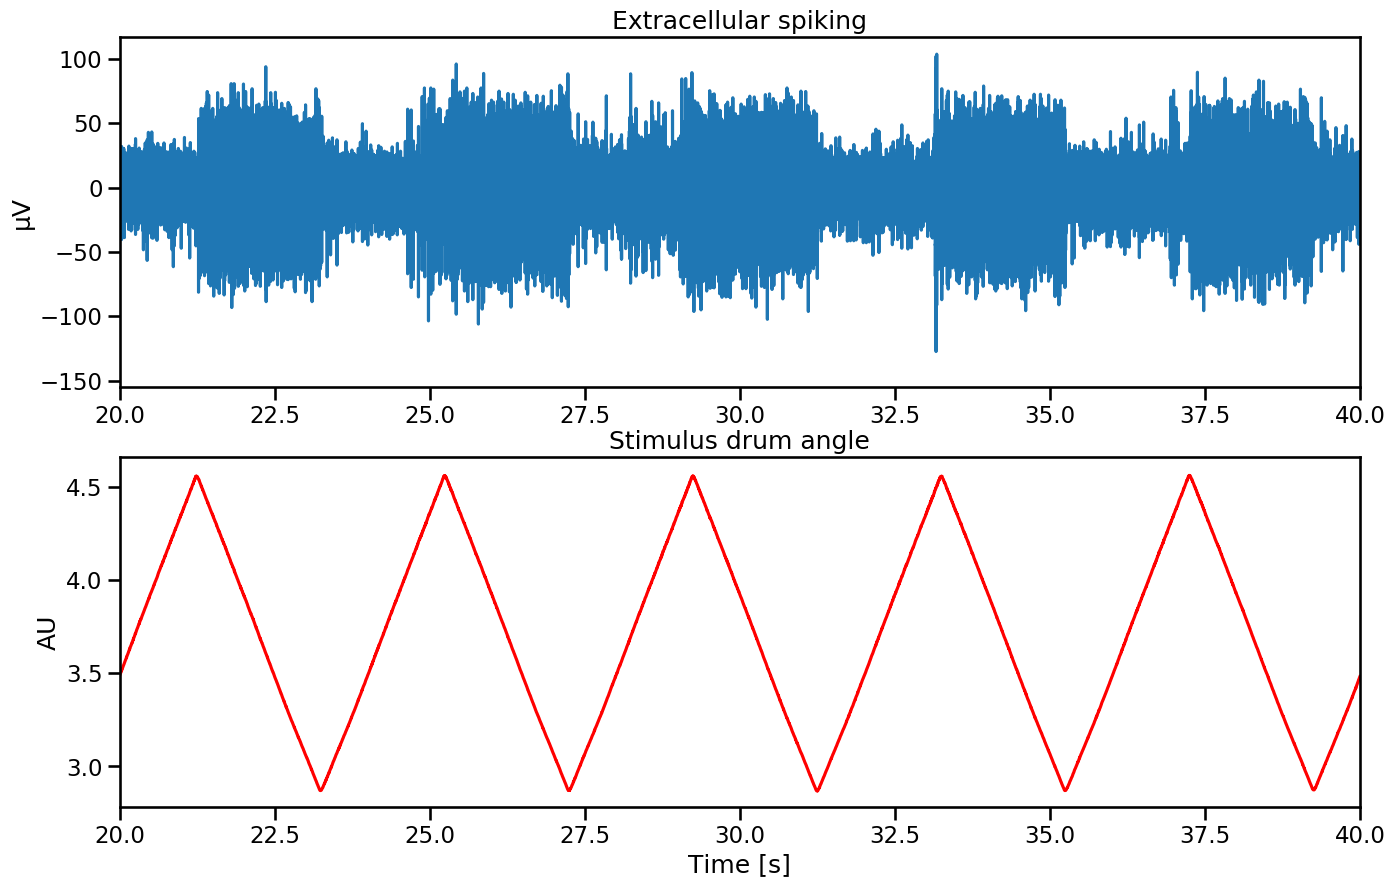

In [3]:
# Let's plot a second of data, from both channels
rcParams["figure.figsize"] = (16,10)
srate = recording.dataRate;
data = recording.data
spk  = data[1,:] .- mean(data[1,:], dims=1)
stim = data[2,:]# ./ maximum(data[2,:], dims=1)*3
pts_per_ms = recording.dataPointsPerMs;
t = recording.sweepX;

subplot(2,1,1) ; plot(t, spk)
title("Extracellular spiking")
ylabel("µV") ; xlim([20, 40])
subplot(2,1,2) ; plot(t, stim, "r")
title("Stimulus drum angle")
xlabel("Time [s]") ; ylabel("AU")
xlim([20, 40]);

## 1 threshold spikes

Note that voltage deflections from MRO spikes in the extracellular recording tend to last at least 3.5 ms or so.

In [35]:
THRESHOLD  = -3 * std(spk)
# THRESHOLD  = -20
SPK_WIN_MS = 6
spkidx    = get_thresholded_spikes(spk, THRESHOLD, SPK_WIN_MS*pts_per_ms)
wfs, tspk = collect_waveforms(spk, spkidx, SPK_WIN_MS, pts_per_ms)
toremoveidx, peaks, troughs = check_bad_wfs(wfs, tspk);

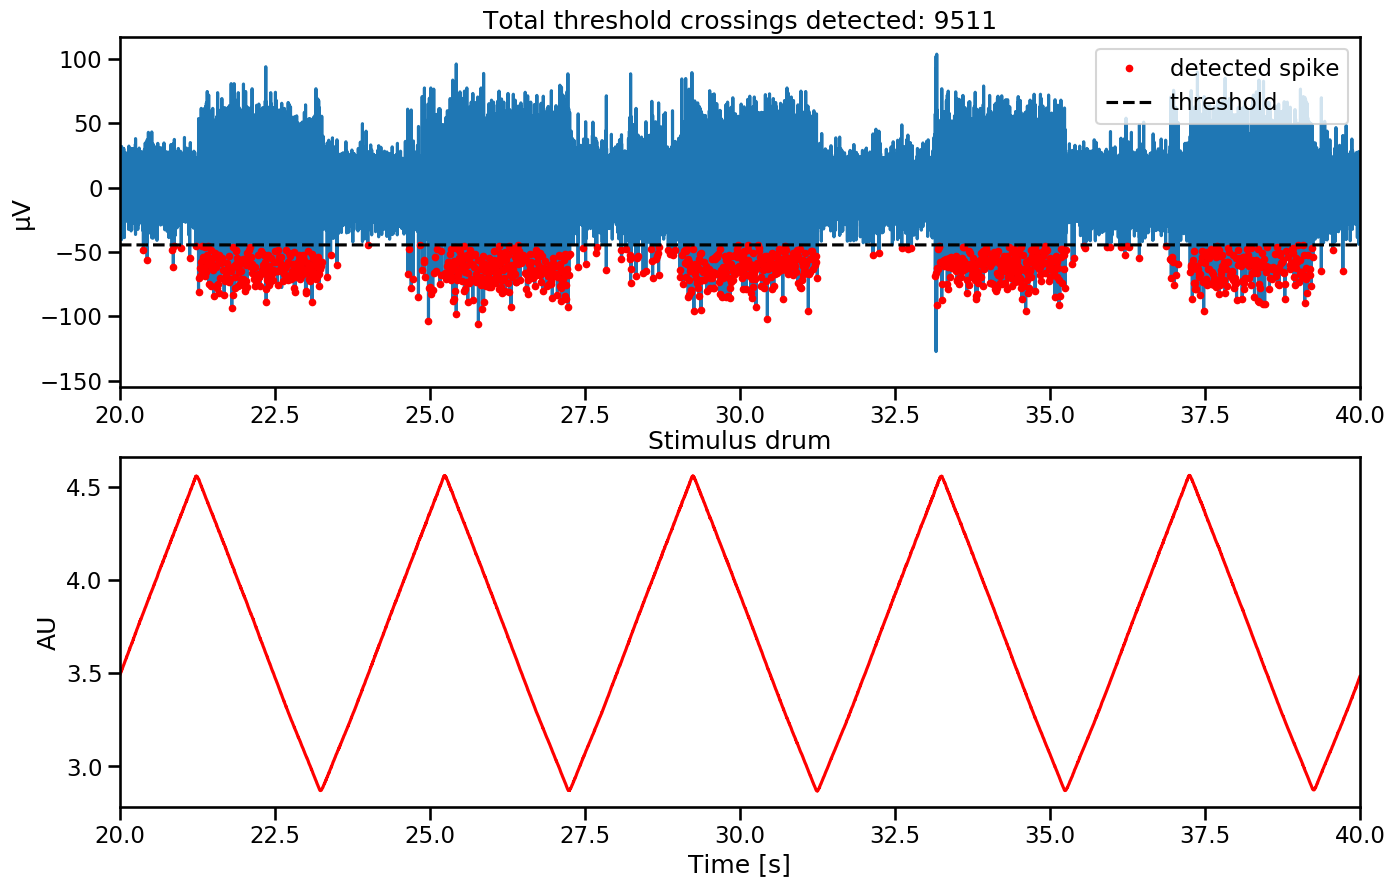

In [36]:
peaks = maximum(wfs, dims=2)
troughs = minimum(wfs, dims=2)

rcParams["figure.figsize"] = (16,10)
figure()
subplot(2,1,1)
plot(t, spk) ; plot(t[spkidx], troughs, "r.", label="detected spike")
plot(t, THRESHOLD .+ zeros(length(t)), "k--",   label="threshold")
ylabel("μV")
title("Total threshold crossings detected: " * string(length(spkidx)))
legend(loc="upper right") ; xlim([20, 40])

subplot(2,1,2)
plot(t, stim, "r")
xlabel("Time [s]") ; ylabel("AU") ; xlim([20 , 40])
title("Stimulus drum")
savefig("fig1-osc-detection.png")

# subplot(2,2,2)
# plot(tspk, transpose(wfs[toremoveidx, :][1:100,:]))
# xlabel("Time [ms]") ; ylabel("μV")
# title("Waveforms to remove, n=" * string(sum(toremoveidx)))

# subplot(2,2,4)
# plot(tspk, transpose(wfs[.~toremoveidx,:][1:100, :]))
# xlabel("Time [ms]") ; ylabel("μV")
# title("Waveforms to remaining, n=" * string(sum(.~toremoveidx)))

In [37]:
# Keep only the good waveforms
wfs    = wfs[.~toremoveidx,:]
spkidx = spkidx[.~toremoveidx];

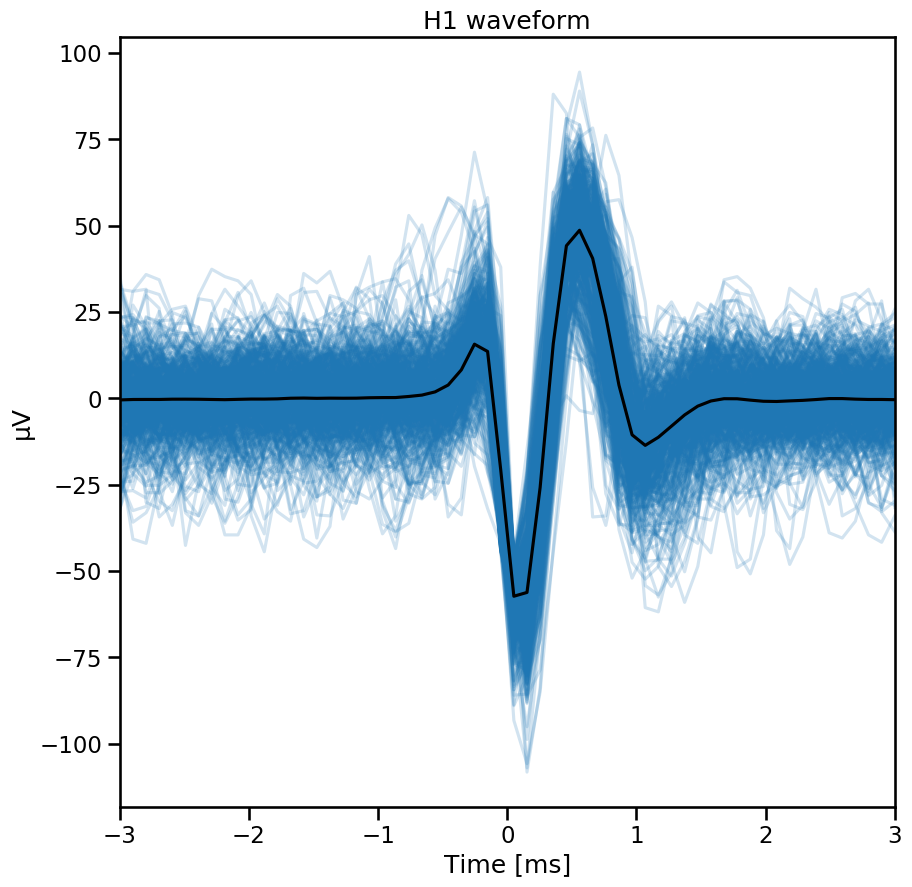

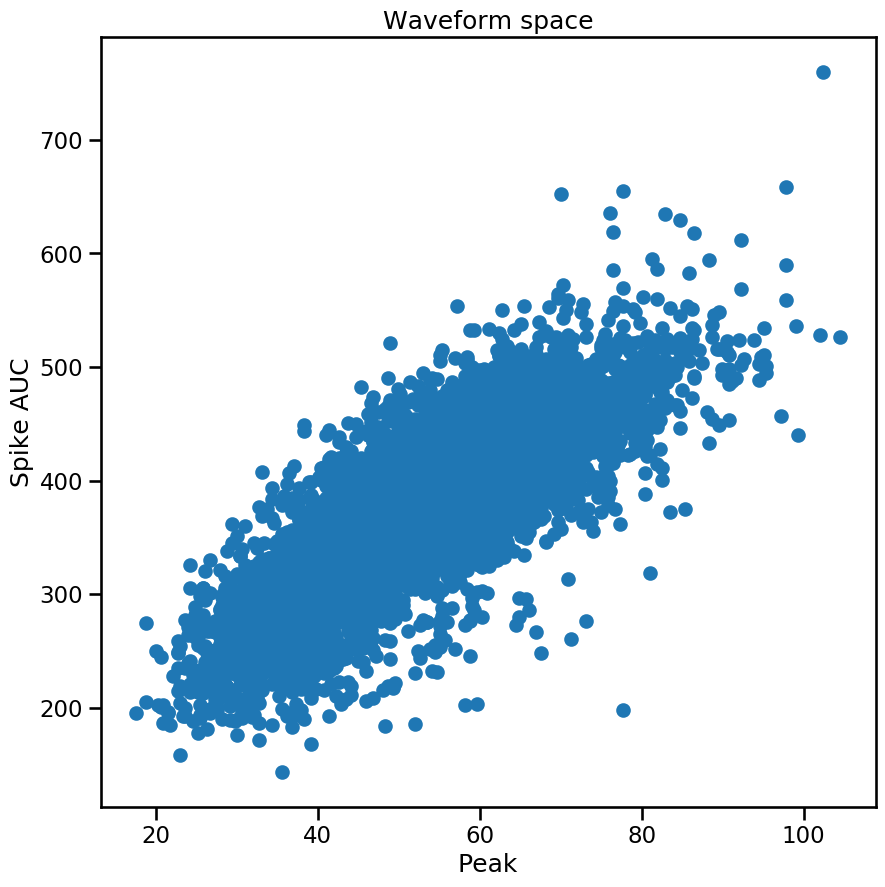

In [15]:
rcParams["figure.figsize"] = (10,10)
figure()
plot(tspk, wfs[1:500,:]', "C0", alpha=0.2)
plot(tspk, mean(wfs, dims=1)', "k") ; xlim([-3, 3])
title("H1 waveform") ; xlabel("Time [ms]") ; ylabel("μV");
savefig("fig1-waveform.png")

figure()
scatter(feats["peak"], feats["spkauc"], color="C0")
title("Waveform space") ; xlabel("Peak") ; ylabel("Spike AUC")
savefig("fig1-wfspace.png")

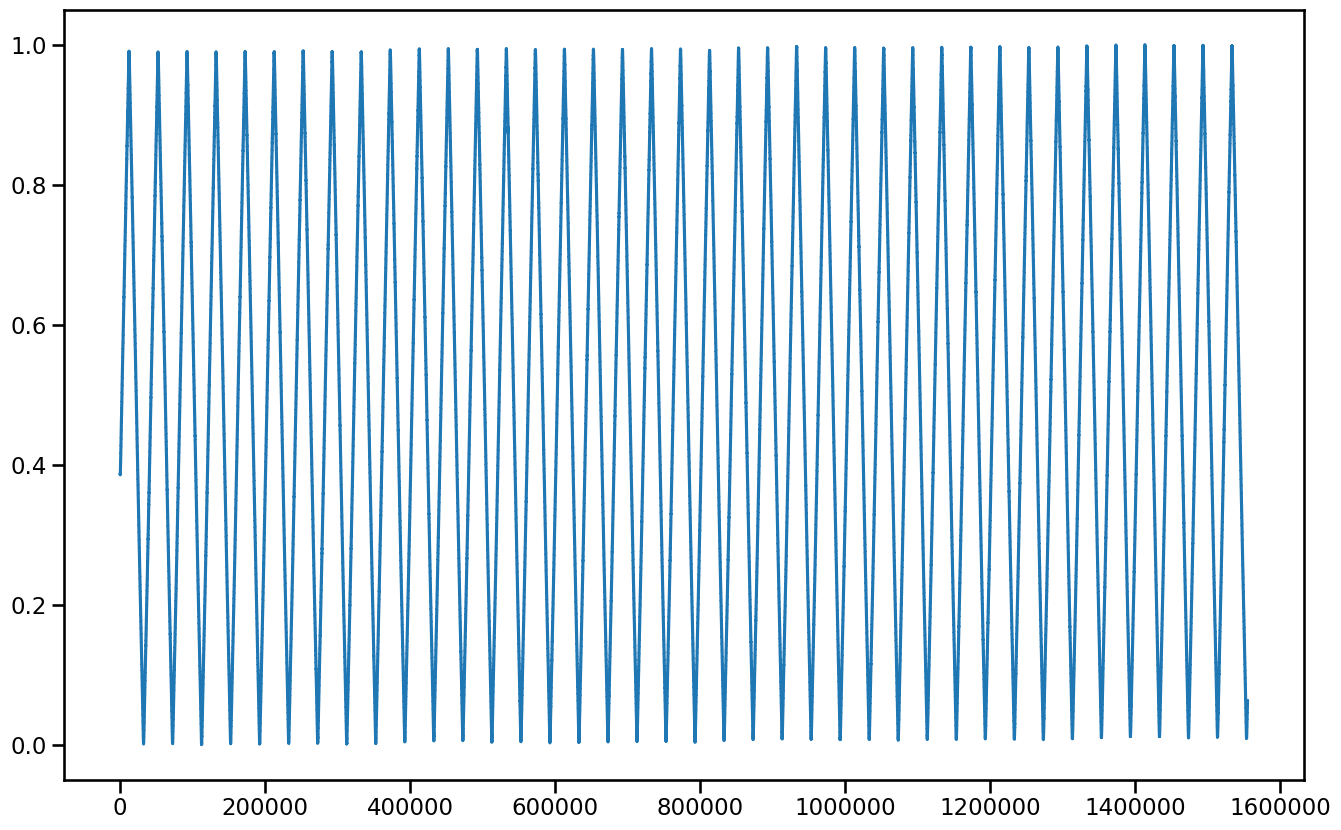

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1a80204650>

In [67]:
plot(stim)

In [38]:
include("spike_utils.jl")
spk, stim, t, srate, pts_per_ms = load_fly_data("data/19o09012-fly2-csf-osc-ccw-5s-2so.abf");

THRESHOLD  = -3 * std(spk)
SPK_WIN_MS = 6
spkidx = get_thresholded_spikes(spk, THRESHOLD, SPK_WIN_MS*pts_per_ms)
wfs, tspk = collect_waveforms(spk, spkidx, SPK_WIN_MS, pts_per_ms)
toremoveidx, peaksrm, troughsrm = check_bad_wfs(wfs, tspk)

# Keep only the good waveforms
wfs    = wfs[.~toremoveidx,:]
spkidx = spkidx[.~toremoveidx];

feats = compute_wf_features(wfs, tspk);

# Find peaks and troughs in the osc stim signal
peaks_thresh_idx   = findall(stim .> 0.98)
troughs_thresh_idx = findall(stim .< 0.02)
interpeaks   = findall(diff(peaks_thresh_idx)   .> 5) ; pushfirst!(interpeaks, 1)
intertroughs = findall(diff(troughs_thresh_idx) .> 5) ; pushfirst!(intertroughs, 1)
peaks_idx = [] ; troughs_idx = [];
for i = 1 : length(interpeaks) - 1
    push!(peaks_idx, maximum(peaks_thresh_idx[interpeaks[i] : interpeaks[i+1]]))
end
for i = 1 : length(intertroughs) - 1
    push!(troughs_idx, maximum(troughs_thresh_idx[intertroughs[i] : intertroughs[i+1]]))
end

ccw_trials = zeros(Int, length(peaks_idx), 2)
cw_trials  = zeros(Int, length(troughs_idx)-1, 2)

ccw_trials[:,1] = peaks_idx
ccw_trials[:,2] = troughs_idx
cw_trials[:,1] = troughs_idx[1:end-1]
cw_trials[:,2] = peaks_idx[2:end]

# Get cw and ccw trials
ccwtrl = collect_trials(spk, t, stim, spkidx, wfs, feats["peak"], feats["trough"], ccw_trials)
cwtrl  = collect_trials(spk, t, stim, spkidx, wfs, feats["peak"], feats["trough"], cw_trials)

# Compute instantaneous firing rates
SIZE_MS = 200
# window = DSP.Windows.rect(SIZE_MS * s[1]["pts_per_ms"])
# window = DSP.Windows.triang(SIZE_MS * pts_per_ms)
ccwtrl = compute_trl_frs(ccwtrl, ones(SIZE_MS * pts_per_ms), pts_per_ms)
cwtrl  = compute_trl_frs(cwtrl,  ones(SIZE_MS * pts_per_ms), pts_per_ms);

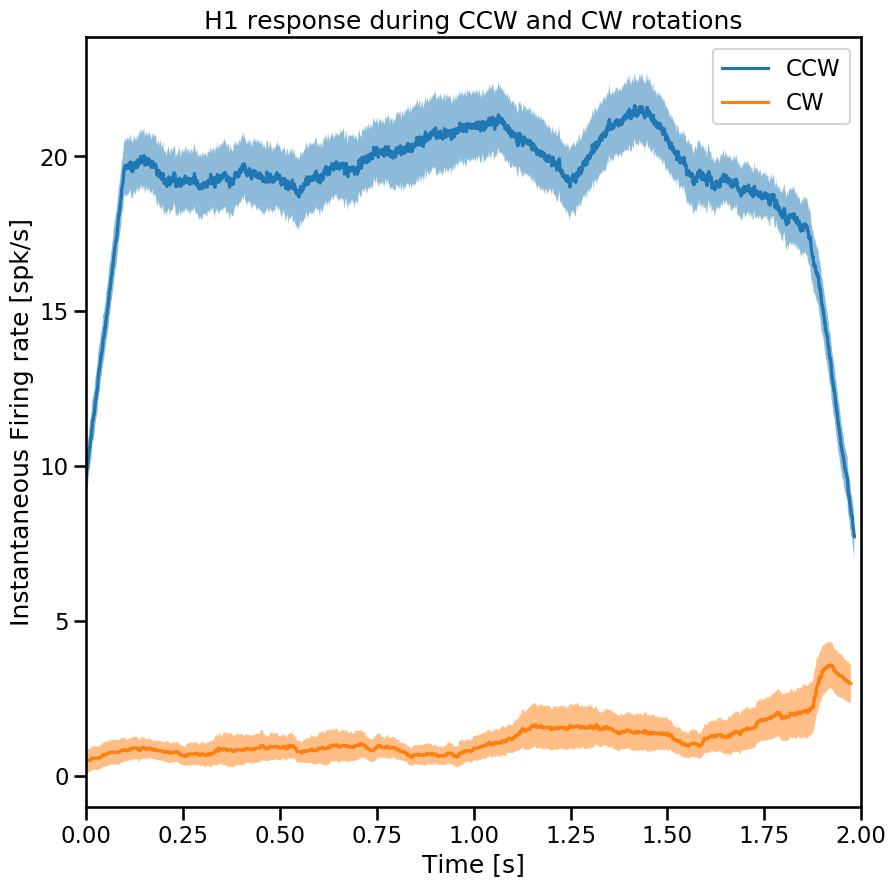

In [41]:
rcParams["figure.figsize"] = (10,10)
figure()
plot(ccwtrl["t_ifr"], dropdims(ccwtrl["ifr"], dims=2))
ci95ccw = 1.96 * std(ccwtrl["ifrs"], dims=2) ./ sqrt(ccwtrl["ntrials"])
fill_between(ccwtrl["t_ifr"], dropdims(ccwtrl["ifr"]-ci95ccw, dims=2), dropdims(ccwtrl["ifr"]+ci95ccw, dims=2), alpha=0.5)

plot(cwtrl["t_ifr"],  dropdims(cwtrl["ifr"], dims=2))
ci95cw = 1.96 * std(cwtrl["ifrs"], dims=2) ./ sqrt(cwtrl["ntrials"])
fill_between(cwtrl["t_ifr"], dropdims(cwtrl["ifr"]-ci95cw, dims=2), dropdims(cwtrl["ifr"]+ci95cw, dims=2), alpha=0.5)

xlim([0, 2]) ; xlabel("Time [s]") ; ylabel("Instantaneous Firing rate [spk/s]")
title("H1 response during CCW and CW rotations")
legend(["CCW", "CW"])
savefig("fig1-ccw-vs-cw-response.png")

In [26]:
size(ccwtrl["t_ifr"])

(19823,)

In [27]:
size(ccwtrl["ifr"])

(19823, 1)

In [17]:
rcParams["figure.figsize"] = (16,10)
plot(cwtrl["t_ifr"], cwtrl["ifr"])
    ci95 = 1.96 .* std(cwtrl["ifrs"], dims=2) ./ sqrt(length(s[isess]["trl"]))
end
plot(ccwtrl["t_ifr"], ccwtrl["ifr"]);
    ci95 = 1.96 .* std(s[isess]["ifrs"], dims=2) ./ sqrt(length(s[isess]["trl"]))
end
for isess = 1 : length(s)
    plot(s[isess]["t_ifr"], s[isess]["ifr"], label=s[isess]["filepath"], alpha=0.8)
    fill_between(s[isess]["t_ifr"], dropdims(s[isess]["ifr"]-ci95, dims=2), dropdims(s[isess]["ifr"]+ci95, dims=2), alpha=0.5)
end

legend()

UndefVarError: UndefVarError: s not defined

In [60]:
ccw_lens = [] ; cw_lens = []
for i = 1 : cwtrl["ntrials"]
    push!(cw_lens, length(cwtrl[i]["t"]))
end
for i = 1 : ccwtrl["ntrials"]
    push!(ccw_lens, length(ccwtrl[i]["t"]))
end

In [63]:
mean(cw_lens)

16172.783783783783

In [64]:
mean(ccw_lens)

23868.105263157893

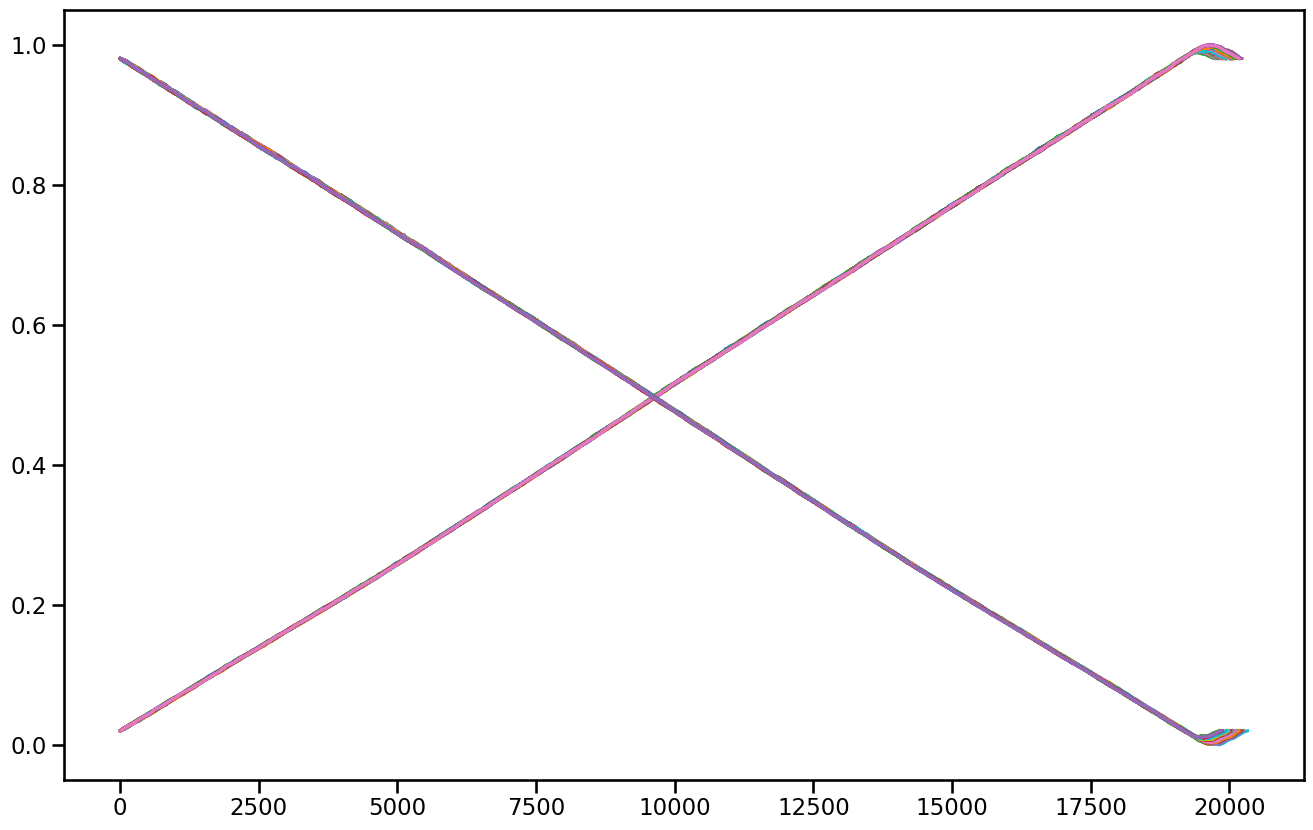

In [75]:
for i = 1 : cwtrl["ntrials"]
    plot(cwtrl[i]["stim"])
end
for i = 1 : ccwtrl["ntrials"]
    plot(ccwtrl[i]["stim"])
end

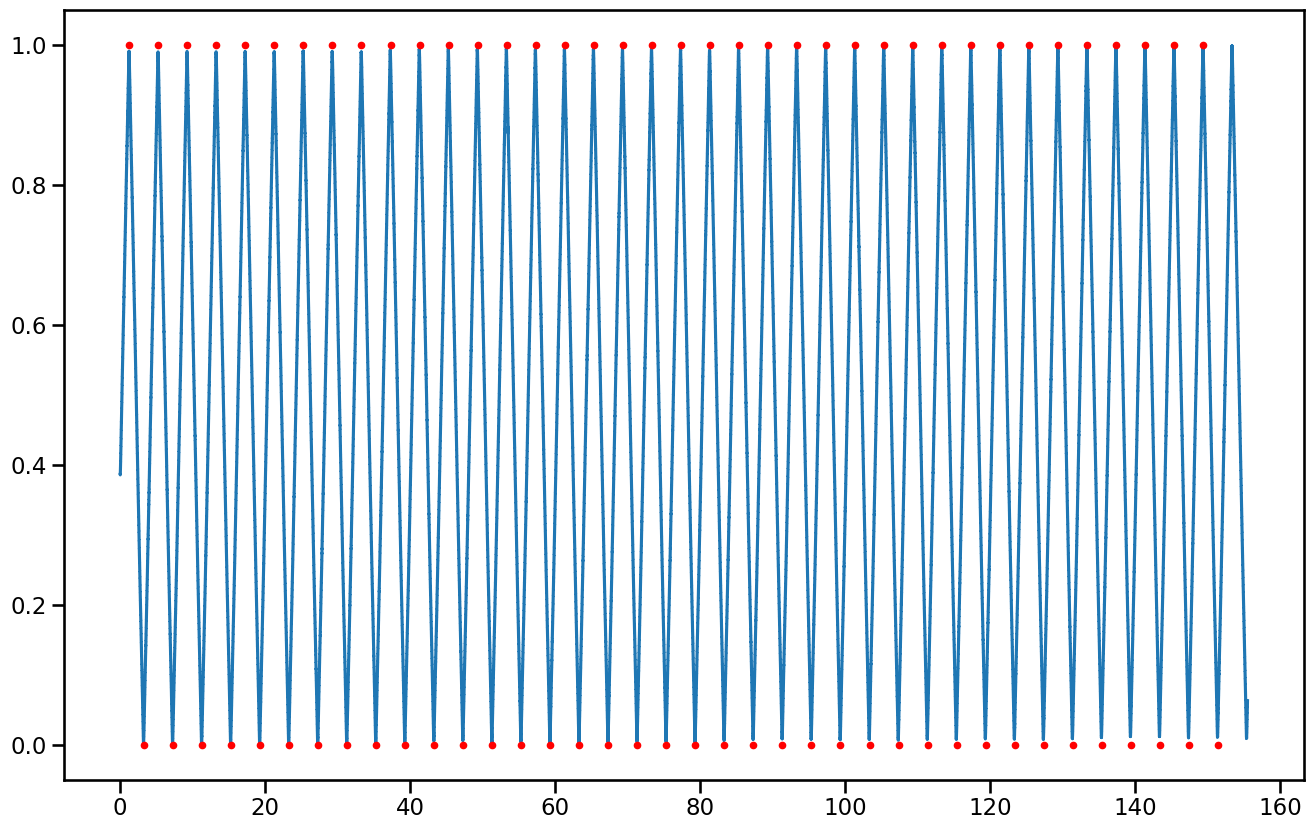

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1a85072490>

In [74]:
plot(t, stim)
plot(t[peaks_idx], ones(length(peaks_idx)), "r.")
plot(t[troughs_idx], zeros(length(troughs_idx)), "r.");

In [102]:
binsize_ms = 10
i = 1
t_fr = 0 : (binsize_ms * pts_per_ms) : (length(ccwtrl[i]["t"])/pts_per_ms/1000)

0.0:100.0:0.0

In [105]:
length(ccwtrl[i]["t"])

20267

In [109]:
ccwtrl[i]["troughs"][]

203-element Array{Float64,1}:
  -47.156097412109375
  -54.175140380859375
  -50.513031005859375
  -84.38754272460938 
  -66.38217163085938 
  -58.752777099609375
  -63.635589599609375
  -62.414886474609375
  -46.545745849609375
  -48.376800537109375
  -62.109710693359375
  -51.123382568359375
  -57.837249755859375
    ⋮                
  -61.804534912109375
  -73.70639038085938 
  -71.26498413085938 
  -53.564788818359375
  -57.837249755859375
  -62.414886474609375
  -46.545745849609375
  -66.68734741210938 
  -47.461273193359375
 -108.19125366210938 
  -75.23226928710938 
  -53.564788818359375

## 2 & 3 spike statistics, plotting

Compute waveform statistics

In [125]:
features = Dict()
features["auc"]     = sum(wfs, dims=2)
features["absauc"]  = sum(abs.(wfs), dims=2)
features["spkauc"]  = sum(abs.(wfs[:, Int(length(tspk)/2):Int(length(tspk)/2)+10]), dims=2)
features["peak"]    = maximum(wfs, dims=2)
features["trough"]  = minimum(wfs, dims=2)
features["pt_dist"] = features["peak"] .- features["trough"];
feats = collect(keys(features))

# rcParams["figure.figsize"] = (10,25)
# subplot(9,3,1)
# scatter(features["auc"], features["pt_dist"], marker=".", linewidths=0.1)
# xlabel("AUC"); ylabel("Peak-trough distance")

# subplot(9,3,2)
# scatter(features["absauc"], features["pt_dist"], marker=".", linewidths=0.1)
# xlabel("Absolute AUC"); ylabel("Peak-trough distance")

# subplot(9,3,3)
# scatter(features["peak"], features["trough"], marker=".", linewidths=0.1)
# xlabel("Peak"); ylabel("Trough")

# subplot(9,3,4)
# scatter(features["spkauc"], features["pt_dist"], marker=".", linewidths=0.1)
# xlabel("spkauc"); ylabel("PT Dist")

# subplot(9,3,5)
# scatter(features["spkauc"], features["absauc"], marker=".", linewidths=0.1)
# xlabel("spkauc"); ylabel("absauc")

# subplot(9,3,6)
# scatter(features["peak"], features["trough"], marker=".", linewidths=0.1)
# xlabel("peak") ; ylabel("trough")

# subplot(9,3,7)
# scatter(features["peak"], features["spkauc"], marker=".", linewidths=0.1)
# xlabel("peak") ; ylabel("spkauc");
# rcParams["figure.figsize"] = (16,10)

In [126]:
# using Clustering

# kmdata = hcat(features["spkauc"], features["peak"])
# # kmdata = peak
# km = kmeans(transpose(kmdata), 2)
# # Get results
# a = assignments(km) # get the assignments of points to clusters
# c = counts(km)      # get the cluster sizes
# M = km.centers;     # get the cluster centers

# for i = 1 : length(unique(a))
#     scatter(features["spkauc"][a .== i], features["peak"][a .== i], marker=".", linewidths=0.1, color="C" * string(i-1))
# end

In [47]:
# # Collect into dictionary
# # If dealing with multiple spikes
# S = Dict()
# for label = unique(a)
#     S[label] = Dict()
#     S[label]["wfs"]     = wfs[a .== label, :]
#     S[label]["auc"]     = features["auc"][a .== label]
#     S[label]["absauc"]  = features["absauc"][a .== label]
#     S[label]["spkauc"]  = features["spkauc"][a .== label]
#     S[label]["peak"]    = features["peak"][a .== label]
#     S[label]["trough"]  = features["trough"][a .== label]
#     S[label]["pt_dist"] = features["pt_dist"][a .== label]
#     S[label]["spkidx"]  = spkidx[a .== label]
# end

# If not (just working with H1)
# S = Dict()
# S["wfs"]     = wfs
# S["auc"]     = features["auc"]
# S["absauc"]  = features["absauc"]
# S["spkauc"]  = features["spkauc"]
# S["peak"]    = features["peak"]
# S["trough"]  = features["trough"]
# S["pt_dist"] = features["pt_dist"]
# S["spkidx"]  = spkidx;

In [23]:
# # Plot each neuron's average waveform
# for unit = keys(S)
#     figure(figsize=(8,5))
#     subplot(1,2,1)
#     plot(tspk, transpose(S[unit]["wfs"]), alpha=0.3)
#     plot(tspk, reshape(mean(S[unit]["wfs"], dims=1), (60,)), "k--")
#     title("Unit " * string(unit) * ", n=" * string(length(S[unit]["auc"])))
    
#     subplot(1,2,2)
#     hist(diff(S[unit]["spkidx"]), bins=1000); xlim([0, 1000])
#     title("Unit " * string(unit) * " ISI")
# end